In [1]:
import random
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.stats as sps
import pandas as pd

# COIN-TOSS

A Mechanism is differentially private if for all $S \subseteq \operatorname{Range}(\mathcal{M})$ and for all $x, y \in \mathbb{N}|\mathcal{N}|$ such that $||x − y||1 \leq 1$:

$$Pr[\mathcal{M}(x)\in S]\leq e^\epsilon Pr[\mathcal{M}(y)\in S]+\delta$$

where the probability space is over the coin flips of the mechanism 𝓜. If $\delta = 0$, we say that M is 𝜀-differentially private.


In [2]:
def trivialCointoss(data):
    size = len(data)
    outputs = []
    for i in range(size):
        if random.random()>0.5:
            outputs.append(data[i])
        else:
            outputs.append(1 if random.random() > 0.5 else 0)

    return outputs

In [3]:
def getOriginalProbabilities(data):
    Y = np.sum(data)/len(data)
    p = 2*Y - 1/2
    return p

In [4]:
datasize = 100000
p0 = 0.25
data = [1 if random.random() < p0 else 0 for i in range(datasize)]
tct = trivialCointoss(data)
print(f"original p:{p0} - observed {getOriginalProbabilities(tct):.2f}")

p1 = 0.5
data = [1 if random.random() < p1 else 0 for i in range(datasize)]
tct = trivialCointoss(data)
print(f"original p:{p1} - observed {getOriginalProbabilities(tct):.2f}")

p2 = 0.7
data = [1 if random.random() < p2 else 0 for i in range(datasize)]
tct = trivialCointoss(data)
print(f"original p:{p2} - observed {getOriginalProbabilities(tct):.2f}")

p3 = 0.8
data = [1 if random.random() < p3 else 0 for i in range(datasize)]
tct = trivialCointoss(data)
print(f"original p:{p3} - observed {getOriginalProbabilities(tct):.2f}")


original p:0.25 - observed 0.25
original p:0.5 - observed 0.50
original p:0.7 - observed 0.70
original p:0.8 - observed 0.80


In [5]:
def verifyCointoss(trueAnswers, cointoss):
    #probability of simulated yes where the true answer was yes
    prx = len(np.where((np.array(cointoss)==1) & (np.array(trueAnswers)==1))[0])/len(np.where(np.array(trueAnswers)==1)[0])
    # probaility of sumulated yes where thee true answer was no
    pry = len(np.where((np.array(cointoss)==1) & (np.array(trueAnswers)==0))[0])/len(np.where(np.array(trueAnswers)==0)[0])

    return prx/pry

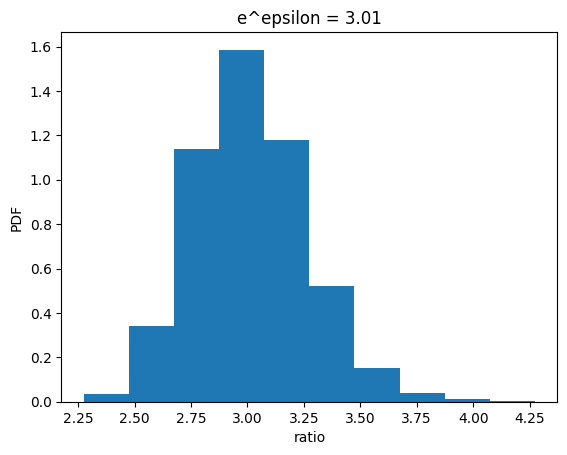

In [6]:
simsize = 10000
datasize= 1000
probabilities = []
for s in range(simsize):
    data = [1 if random.random() < 0.5 else 0 for i in range(datasize)]
    probabilities.append(verifyCointoss(data, trivialCointoss(data)))

plt.hist(probabilities, density=True)
plt.ylabel("PDF")
plt.xlabel("ratio")
plt.title(f"e^epsilon = {np.mean(probabilities):.2f}")
plt.show()

In [7]:
def epsilonCointoss(data, epsilon=1e-5):
    size = len(data)
    outputs = []
    p_yes = np.exp(epsilon) / (1 + np.exp(epsilon))  # Probability of keeping true value
    print(f"p_yes (retain true value): {p_yes}")  # Debugging output
    for i in range(size):
        if random.random() < p_yes:  # With probability p_yes, retain the true value
            outputs.append(data[i])
        else:  # Otherwise, flip a coin to generate a random 0 or 1
            outputs.append(1 if random.random() > 0.5 else 0)
    return outputs

# Updated function to compute the original probabilities
def getEpsilonOriginalProbabilities(data, epsilon=1e-5):
    Y = np.sum(data) / len(data)  # Proportion of 1s in the perturbed data
    p_yes = np.exp(epsilon) / (1 + np.exp(epsilon))  # Probability of keeping true value
    print(f"Proportion of 1s in noisy data (Y): {Y}")  # Debugging output
    p = (Y - 0.5 * (1 - p_yes)) / p_yes
    print(f"Estimated original probability (p): {p}")  # Debugging output
    return p

In [8]:
datasize = 100000
p0 = 0.25
epsilon = np.log(1.1)
print(f"epsilon: {epsilon}")

data = [1 if random.random() < p0 else 0 for i in range(datasize)]

tct = epsilonCointoss(data, epsilon)
original_p = getEpsilonOriginalProbabilities(tct, epsilon)
print(f"original p: {p0} - observed {original_p:.2f}")

epsilon: 0.09531017980432493
p_yes (retain true value): 0.5238095238095238
Proportion of 1s in noisy data (Y): 0.36837
Estimated original probability (p): 0.24870636363636361
original p: 0.25 - observed 0.25


# LAPLACE MECHANISM

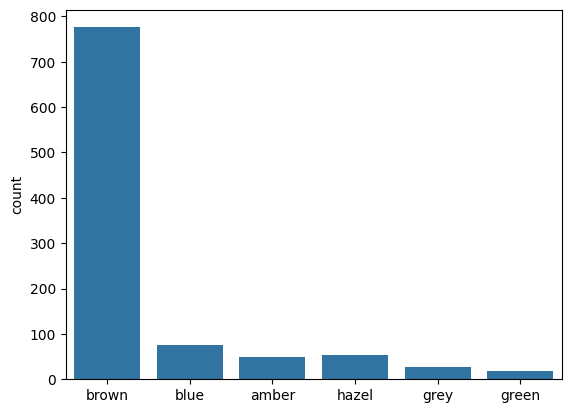

In [9]:
colors  = ["blue", "green", "amber", "brown", "hazel", "grey"]
frequencies = [0.08, 0.02, 0.05, 0.77, 0.05, 0.03]
eye_color = npr.choice(colors, size=1000, p=frequencies)
sns.countplot(x=eye_color)
plt.show()

In [10]:
def laplace_mechanism(original_values, epsilon=1e-5, sensitivity=1):
    outputs = original_values + npr.laplace(scale = sensitivity/epsilon, loc=0, size=len(original_values))
    return outputs

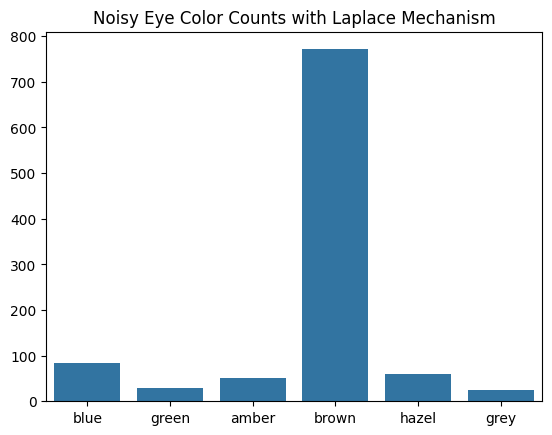

In [11]:
# Calculate true counts of eye colors
true_counts = [list(eye_color).count(color) for color in colors]

# Apply Laplace Mechanism
epsilon = 0.1  # Adjust the privacy budget
noisy_counts = laplace_mechanism(np.array(true_counts), epsilon=epsilon)

# Visualize the noisy counts
sns.barplot(x=colors, y=noisy_counts)
plt.title("Noisy Eye Color Counts with Laplace Mechanism")
plt.show()

## COUNT QUERIES

In [12]:
blue_eyes = [len(np.where(eye_color=='blue')[0])]
epsilon = 1
print(f"original {blue_eyes} - observed {laplace_mechanism(blue_eyes, epsilon)}")

original [76] - observed [74.54071016]


In [13]:
blue_eyes = [len(np.where(eye_color=='blue')[0])]
sensitivity = 1 #what is the sensitivity of a count query
delta = 0.05
epsilon = 0.5
query_dimension = len(blue_eyes)
exp_samples = 100000

ratio = np.log(query_dimension/delta)*(sensitivity/epsilon)
errors = [np.abs((blue_eyes-laplace_mechanism(blue_eyes, epsilon)))>=ratio for i in range(exp_samples)]
print(f"probability of having an error bigger than {ratio:.3f}: {np.sum(errors)/len(errors):.3f} -- expected <= {delta}")

probability of having an error bigger than 5.991: 0.050 -- expected <= 0.05


## HISTOGRAM QUERIES

In [14]:
_, histogram = np.unique(eye_color, return_counts=True)
epsilon = 0.005
perturbedHistogram = laplace_mechanism(histogram, epsilon)

print(f"original {histogram} - observed {perturbedHistogram}")

original [ 50  76 776  19  26  53] - observed [ 140.77980404  198.6842963   839.36982597  -47.08728768 -218.02707512
  -33.4333775 ]


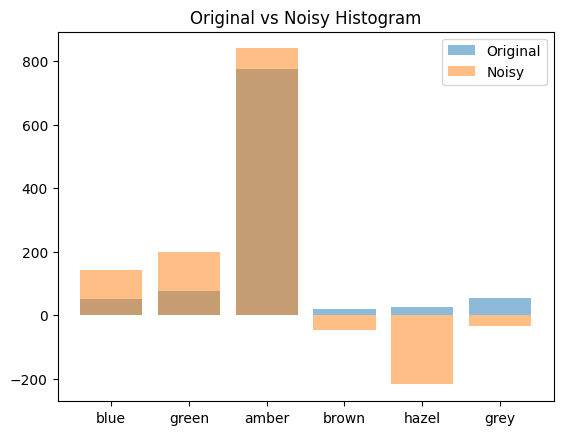

In [15]:
import matplotlib.pyplot as plt
plt.bar(colors, histogram, alpha=0.5, label="Original")
plt.bar(colors, perturbedHistogram, alpha=0.5, label="Noisy")
plt.legend()
plt.title("Original vs Noisy Histogram")
plt.show()

In [16]:
sensitivity = 1
query_dimension = len(histogram)
epsilon = 0.05
delta = 0.05
ratio = np.log(query_dimension/delta)*(sensitivity/epsilon)

errors = [np.max(np.abs(laplace_mechanism(histogram, epsilon)-histogram))>=ratio for i in range(exp_samples)]

print(f"probability of having an error bigger than {ratio:.3f}: {np.sum(errors)/len(errors):.3f} -- expected <= {delta}")

probability of having an error bigger than 95.750: 0.049 -- expected <= 0.05


## REPORT NOISY MAX

In [17]:
def report_noisy_max(dataset, epsilon=1):
    labels, counts = np.unique(dataset, return_counts=True)
    noisy_max = np.argmax(laplace_mechanism(counts, epsilon))
    return labels[noisy_max]

epsilon = 0.05
report_noisy_max(eye_color, epsilon)

'brown'

# EXPONENTIAL MECHANISM

In [18]:
#private bids
private_bids = [0.41, 0.1, 0.1, 0.1]

#possible prices
R_size = 101
R = [round(r, 2) for r in np.linspace(0,1, R_size)] #just to avoid numerical errors


In [19]:
def utility(R, bids):
    #define the utility values that can be observed, given the prices and the bids
    utilities = []

    #put here the computation of the utility
    for p in R:
        utilities.append(p*len([b for b in bids if b>=p]))
    return np.array(utilities)

In [20]:
perturbed_utils = []
true_utility = utility(R, private_bids)
for i in range(len(private_bids)):
    perturbed_utils.append(utility(R, private_bids[:i]+private_bids[i+1:]))
perturbed_utils.append(utility(R, [1]+private_bids))

sensitivity = np.max([np.max(np.abs(true_utility-pu)) for pu in perturbed_utils])


In [21]:
def exponential_mechanism(R, true_utility, sensitivity, epsilon=0.5):

    probabilities = np.exp(true_utility*(epsilon/(2*sensitivity)))
    probabilities /= np.sum(probabilities)
    output = npr.choice(R, p=probabilities)

    return output, probabilities


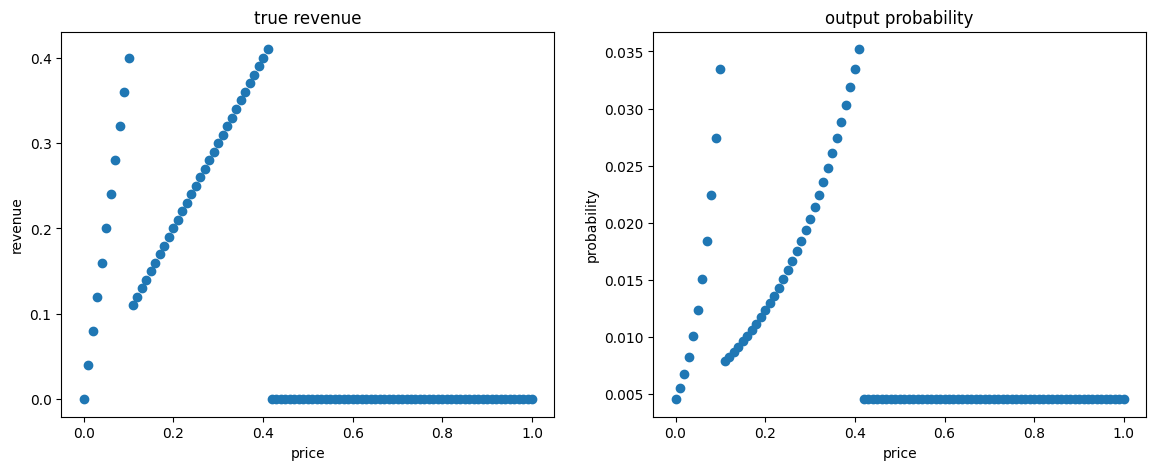

best price: 0.41 - optimal utility: 0.41
output value: 0.27 - revenue: 0.27


In [22]:
epsilon = 10


sampled_price, probabilities = exponential_mechanism(R, true_utility, sensitivity, epsilon)



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))



ax1.set(title = "true revenue", xlabel = "price", ylabel = "revenue")
ax1.scatter(R, true_utility)


ax2.set(title = "output probability", xlabel = "price", ylabel = "probability")
ax2.scatter(R, probabilities)
plt.show()

revenue = utility([sampled_price], private_bids)[0]
optimal_revenue = true_utility[np.argmax(true_utility)]
print(f"best price: {R[np.argmax(true_utility)]} - optimal utility: {optimal_revenue:.2f}")
print(f"output value: {sampled_price:.2f} - revenue: {revenue:.2f}");

In [23]:
t = 3 #gives ~0.05 of probability
epsilon = 10
Ropt_size=1

max_error = (2*sensitivity/epsilon*(np.log(R_size/Ropt_size)+t))
acceptable_value = optimal_revenue - max_error
exp_samples = 1000
errors = []
for e in range(exp_samples):
    r, _ = exponential_mechanism(R, true_utility, sensitivity, epsilon)
    observed_utility = utility([r], private_bids)[0]
    errors.append(observed_utility<=acceptable_value)

print(f"probability of having an error bigger than {max_error:.2f} {np.sum(errors)/len(errors):.3f} <= {np.exp(-t):.2f}")

probability of having an error bigger than 1.52 0.000 <= 0.05


# SEQUENTIAL COMPOSITION

In [24]:
heartdf = pd.read_csv("heart.csv")

In [25]:
def laplace_mechanism(original_values, epsilon=1e-5, sensitivity=1):
    """
    Applies the Laplace mechanism to either a single value or an array of values.
    """
    if np.isscalar(original_values):
        noise = np.random.laplace(scale=sensitivity/epsilon)
        return original_values + noise
    else:
        outputs = original_values + np.random.laplace(scale=sensitivity/epsilon, size=len(original_values))
        return outputs


real_count = (heartdf["trtbps"] > 160).sum()
epsilon = 0.1
protected_value = laplace_mechanism(real_count, epsilon)

print(f"The protected value is {protected_value} ... probably not {real_count}")

The protected value is 3.0654736642415976 ... probably not 15


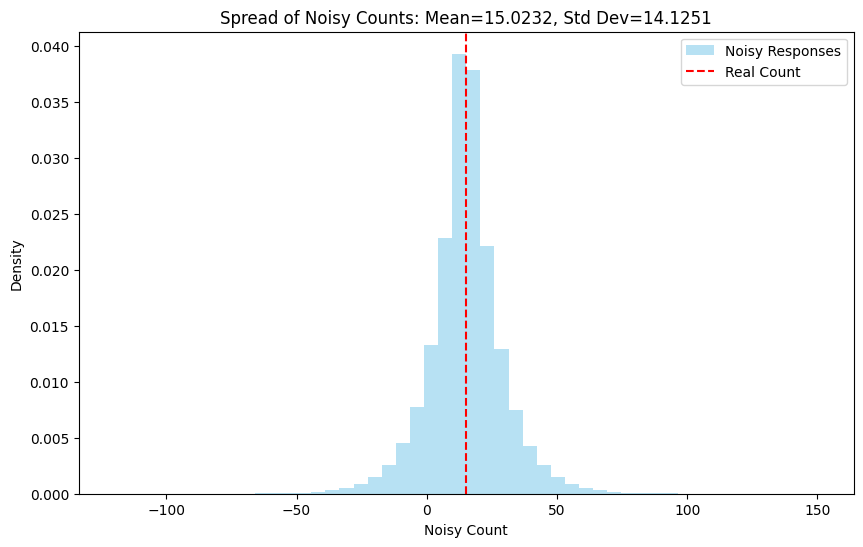

In [26]:
replicates = 1000000
responses = [laplace_mechanism(real_count, epsilon) for _ in range(replicates)]

plt.figure(figsize=(10, 6))
plt.hist(responses, alpha=0.6, bins=50, density=True, color="skyblue", label="Noisy Responses")

plt.axvline(real_count, color='red', linestyle='--', linewidth=1.5, label="Real Count")
plt.title(f"Spread of Noisy Counts: Mean={np.mean(responses):.4f}, Std Dev={np.std(responses):.4f}")
plt.xlabel("Noisy Count")
plt.ylabel("Density")
plt.legend(loc="upper right")
plt.show()

Assume you have a $\varepsilon_1$ differentially private Laplace mechanism and a second mechanism wich is $\varepsilon_2$ differentially private

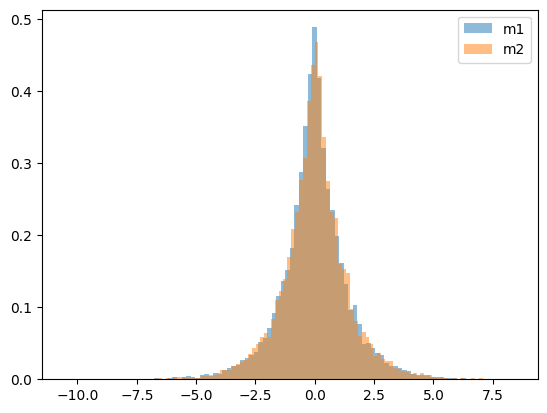

In [27]:
epsilon1 = 1
epsilon2 = 1
l1 = npr.laplace(scale = 1/epsilon1, loc=0, size=10000)
plt.hist(l1, bins=100, alpha=0.5, density=True)
l2 = npr.laplace(scale = 1/epsilon2, loc=0, size=10000)
plt.hist(l2, bins=100, alpha=0.5, density=True)
plt.legend(["m1", "m2"])
plt.show()

What happens if we combine the two mechanisms?

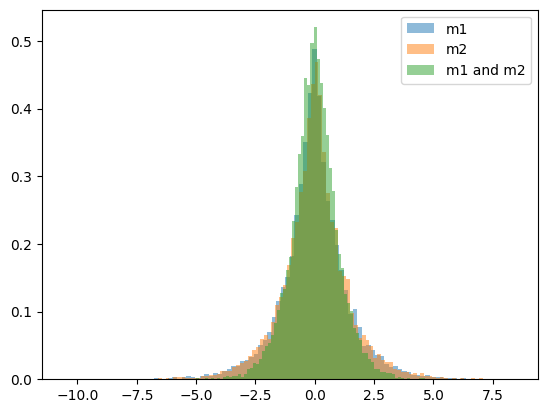

In [28]:
plt.hist(l1, bins=100,alpha=0.5, density=True)
plt.hist(l2, bins=100,alpha=0.5, density=True)
plt.hist((l1+l2)/2, bins=100,alpha=0.5, density=True)
plt.legend(["m1", "m2", "m1 and m2"])

plt.show()

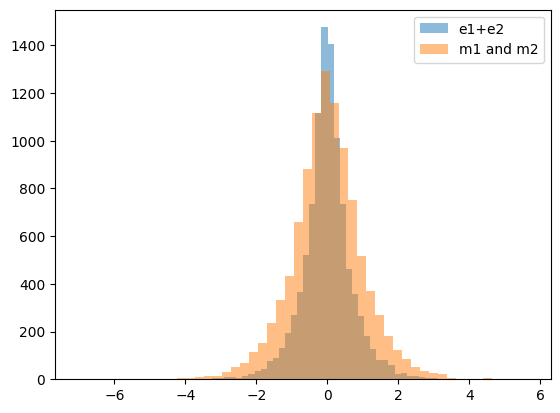

In [29]:
plt.hist(npr.laplace(scale = 1/(epsilon1+epsilon2), loc=0, size=10000), bins=50,alpha=0.5)
plt.hist((l1+l2)/2, bins=50,alpha=0.5)
plt.legend(["e1+e2", "m1 and m2"])
plt.show()

<h5>We can see from the plot above that the orange one with the noise is broader than the one without noise</h5>

# SPARSE VECTOR

<h5> This code implements a differential privacy mechanism for answering threshold-based queries on a dataset using the Laplace Mechanism. It determines whether queries on data exceed a noisy threhold while preserving privacy</h5>

In [30]:
heartdf = pd.read_csv("heart.csv")

heartdf

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [31]:
def sparse_vectors(data, queries, threshold, epsilon=0.5):
    threshold_perturbed = npr.laplace(threshold, 2/epsilon)

    for q in queries:
        qnoise = npr.laplace(0, 4/epsilon)
        if (q(data) + qnoise) >= threshold_perturbed:
            yield "ABOVE"
            break
        else:
            yield "BELOW"

In [79]:
scores = heartdf["trtbps"].values

queries = [lambda x: x[0],
           lambda x: x[1],
           lambda x: x[2],
           lambda x: x[3],
           lambda x: x[4],
           lambda x: x[5],
           lambda x: x[6],
           lambda x: x[7],
           lambda x: x[8],
           lambda x: x[9]]

output = list(sparse_vectors(scores, queries, 150, epsilon=10))
print(scores[:10],output)

[145 130 130 120 120 140 140 120 172 150] ['BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'ABOVE']


In [33]:
#TEST TEST TEST
queries = [
    lambda x: x["chol"].mean(),  #mean cholesterol level
    lambda x: x["age"].mean(),   #mean age
    lambda x: x["trtbps"].max(), #maximum resting blood pressure
    lambda x: x["thalachh"].min(),  #minimum heart rate
    lambda x: x["chol"].mean(),  #mean of cholesterol
]
output = list(sparse_vectors(heartdf, queries, threshold=200, epsilon=10))

print("Output:", output)

Output: ['ABOVE']


In [34]:
#c limits the 'above' answers i get, delta=little number to approximately
#differential privacy (0 is used for pure differential privacy)
def sparse(data, queries, threshold, epsilon, c, delta=0):
    if delta == 0:
        sigma = 2 * c / epsilon
    else:
        sigma = np.sqrt(32 * c * np.log(1 / delta)) / epsilon

    threshold_hat = threshold + npr.laplace(0, sigma)
    count = 0

    outputs = []
    for q in queries:
        vi = npr.laplace(0, 2 * sigma)
        if q(data) + vi >= threshold_hat:
            outputs.append("ABOVE")
            count += 1
            threshold_hat = threshold + npr.laplace(0, sigma)
        else:
            outputs.append("BELOW")

        if count >= c:
            break

    return outputs

In [66]:
def numeric_sparse(data, queries, threshold, c, epsilon, delta=0):
    if delta == 0:
        epsilon1 = (8 / 9) * epsilon
        epsilon2 = (2 / 9) * epsilon
        sigma = lambda e: 2 * c / e
    else:
        epsilon1 = epsilon / np.sqrt(512 + 1)
        epsilon2 = 2 / np.sqrt(512 + 1)
        sigma = lambda e: np.sqrt(32 * c * np.log(1 / delta)) / e

    threshold_hat = threshold + npr.laplace(0, sigma(epsilon1))
    count = 0

    outputs = []
    for q in queries:
        qres = q(data)
        vi = npr.laplace(0, 2 * sigma(epsilon1))
        if qres + vi >= threshold_hat:
            vi2 = npr.laplace(0, sigma(epsilon2))
            result = qres + vi2
            outputs.append(result) #outputs the numerical value of the above threshold queries,
            #which we can do with only a constant factor loss in accuracy
            count += 1
            threshold_hat = threshold + npr.laplace(0, sigma(epsilon1))
        else:
            outputs.append("BELOW")
        if count >= c:
            break

    return outputs

In [92]:
chol = heartdf["chol"].values
cp = heartdf["cp"].values
trtbps = heartdf["trtbps"].values
max_value = heartdf["trtbps"].max()


queries = [
    lambda x: np.mean(x[x > 160]),        #mean of chol > 160
    lambda x: np.mean(x),                 #mean of the entire chol column
    lambda x: np.sum(x > 150),            #count of values > 150
    lambda x: np.std(x),                  #standard deviation of chol column
    lambda x: np.min(x),                  #minimum value in chol column
    lambda x: np.max(x)                   #maximum value in chol column
]

output = list(sparse(chol, queries, 140, epsilon=10,  c=5, delta=1e-5))
print(scores[:10],output)

[233 250 204 236 354 192 294 263 199 168] ['ABOVE', 'ABOVE', 'ABOVE', 'BELOW', 'BELOW', 'ABOVE']


In [93]:
chol = heartdf["chol"].values
cp = heartdf["cp"].values
trtbps = heartdf["trtbps"].values
max_value = heartdf["trtbps"].max()

queries = [
    lambda x: np.mean(x[x > 160]),        #mean of chol > 160
    lambda x: np.mean(x),                 #mean of the entire chol column
    lambda x: np.sum(x > 150),            #count of values > 150
    lambda x: np.std(x),                  #standard deviation of chol column
    lambda x: np.min(x),                  #minimum value in chol column
    lambda x: np.max(x)                   #maximum value in chol column
]


output = list(numeric_sparse(chol, queries, threshold=140, c=5, epsilon=10, delta=1e-5))

print(scores[:10],output)

[233 250 204 236 354 192 294 263 199 168] ['BELOW', 14.435422198974976, -473.56422119749277, -86.7053096527608, 'BELOW', 'BELOW']


<h4>These are examples with the teacher's dataset using my algorithms</h4>

In [67]:
scores = npr.random(size=10)

queries = [lambda x: x[0],
           lambda x: x[1],
           lambda x: x[2],
           lambda x: x[3],
           lambda x: x[4],
           lambda x: x[5],
           lambda x: x[6],
           lambda x: x[7],
           lambda x: x[8],
           lambda x: x[9]]
output = list(sparse(scores, queries, .5, epsilon=10,  c=5, delta=1e-5))
print(scores,output)

[0.03709912 0.77077808 0.5783126  0.79600857 0.68824652 0.98352417
 0.08838695 0.69734936 0.47386148 0.53347405] ['BELOW', 'ABOVE', 'BELOW', 'ABOVE', 'ABOVE', 'ABOVE', 'BELOW', 'BELOW', 'ABOVE']


In [68]:
scores = npr.random(size=10)

queries = [lambda x: x[0],
           lambda x: x[1],
           lambda x: x[2],
           lambda x: x[3],
           lambda x: x[4],
           lambda x: x[5],
           lambda x: x[6],
           lambda x: x[7],
           lambda x: x[8],
           lambda x: x[9]]
output = list(numeric_sparse(scores, queries, .5, epsilon=10,  c=5, delta=1e-5))
print(scores,output)

[0.53787683 0.90474995 0.58598999 0.43542592 0.59451557 0.33017375
 0.1414171  0.83934958 0.25895523 0.28203139] [578.0655058900282, -237.41510112346205, 'BELOW', 'BELOW', -975.4452400160701, -17.86572530785618, 654.0885855687793]


# THE MEAN QUERY

We are going to apply three algorithms:
<ol>
    <li> noisy count to discover the number of subjects </li>
    <li> above_threshold to decide the best clipping </li>
    <li> noisy sum to compute the clipped sum</li>
</ol>

We can assign 1/3 of epsilon to each action.

In [69]:
def clip (v, l, u):
    if v>u:
        return u
    elif v<l:
        return l
    else:
        return v

def clipped_sum(data, l, u):
    return np.array([clip(v, l, u) for v in data]).sum()

# preserves epsilon-differential privacy
def above_threshold(queries, df, T, epsilon):
    T_hat = T + np.random.laplace(loc=0, scale = 2/epsilon)
    for idx, q in enumerate(queries):
        nu_i = np.random.laplace(loc=0, scale = 4/epsilon)
        if q(df) + nu_i >= T_hat:
            return idx
    # if the algorithm "fails", return a random index
    # more convenient in certain use cases
    return random.randint(0,len(queries)-1)


def auto_avg(df, epsilon):
    def create_query(b):
        return lambda df: clipped_sum(df, 0, b) - clipped_sum(df, 0, b+1)

    bs = range(1,150000,5)
    queries = [create_query(b) for b in bs]

    epsilon_svt = epsilon / 3
    final_b = bs[above_threshold(queries, df, 0, epsilon_svt)]

    epsilon_sum = epsilon / 3
    epsilon_count = epsilon / 3


    noisy_sum = npr.laplace(loc=clipped_sum(df, 0, final_b), scale=final_b/epsilon_sum)
    noisy_count = npr.laplace(loc=len(df), scale=1/epsilon_count)

    return noisy_sum/noisy_count

heartdf = pd.read_csv("heart.csv")
data = heartdf['trtbps'].values
#data = np.abs(npr.random(size=100)*50)
print(f"real mean: {np.mean(data)} - dp mean: {auto_avg(data, 1)}")

real mean: 131.62376237623764 - dp mean: 130.61956846189582


<h2>CLIPPING</h2> Controls the influence of outliers by bounding values within a range

<h2>ABOVE THRESHOLD</h2> Dynamically determines the clipping bound to improve accuracy while preserving privacy

<h2>NOISE ADDITION</h2> Laplace noise ensures differential privacy. epsilon/3 is allocated in the 3 stuff.

Larger <Strong>epsilon</strong> reduces noise, improving accuracy but weakening privacy. Smaller <strong>epsilon</strong> increases noise, enhancing privacy but degrading utility.

<h1>Google RAPPOR</h1>
<h5> It is an algorithm created by google to collect statistics on chrome and possibly on the machines it works on.
The transmission of a value v to the server is based on the three phases:
<ol>
<li>encode the value v in a vector B via bloom filter</li>
<li>randomize (and memoize) B in a vector B'</li>
<li>randomize B' in a response S and send it to the server</li>
</ol>
This prevents the averaging attack; it is very difficult to get back to the original value before the bloom filter on.

In [70]:
!pip install ace_tools

In [71]:
import pandas as pd
import hashlib
import hmac
import struct
from random import SystemRandom


heart_data = pd.read_csv("heart.csv")

#RAPPOR parameters
class Params:
    def __init__(self):
        self.num_bloombits = 16
        self.num_hashes = 2
        self.num_cohorts = 64
        self.prob_p = 0.50
        self.prob_q = 0.75
        self.prob_f = 0.50

class _SecureRandom:
    def __init__(self, prob_one, num_bits):
        self.prob_one = prob_one
        self.num_bits = num_bits

    def __call__(self):
        p = self.prob_one
        rand = SystemRandom()
        r = 0
        for i in range(self.num_bits):
            bit = rand.random() < p
            r |= (bit << i)
        return r

class SecureIrrRand:
    def __init__(self, params):
        self.p_gen = _SecureRandom(params.prob_p, params.num_bloombits)
        self.q_gen = _SecureRandom(params.prob_q, params.num_bloombits)

def to_big_endian(i):
    return struct.pack('>L', i)

def get_bloom_bits(word, cohort, num_hashes, num_bloombits):
    value = to_big_endian(cohort) + word
    md5 = hashlib.md5(value)
    digest = md5.digest()
    return [digest[i] % num_bloombits for i in range(num_hashes)]

def get_prr_masks(secret, word, prob_f, num_bits):
    h = hmac.new(secret, word, digestmod=hashlib.sha256)
    digest_bytes = h.digest()
    threshold128 = prob_f * 128
    uniform = 0
    f_mask = 0
    for i in range(num_bits):
        byte = digest_bytes[i]
        u_bit = byte & 0x01
        uniform |= (u_bit << i)
        rand128 = byte >> 1
        noise_bit = (rand128 < threshold128)
        f_mask |= (noise_bit << i)
    return uniform, f_mask

class Encoder:
    def __init__(self, params, cohort, secret, irr_rand):
        self.params = params
        self.cohort = cohort
        self.secret = secret
        self.irr_rand = irr_rand

    def _internal_encode_bits(self, bits):
        uniform, f_mask = get_prr_masks(self.secret, to_big_endian(bits), self.params.prob_f, self.params.num_bloombits)
        prr = (bits & ~f_mask) | (uniform & f_mask)
        p_bits = self.irr_rand.p_gen()
        q_bits = self.irr_rand.q_gen()
        irr = (p_bits & ~prr) | (q_bits & prr)
        return prr, irr

    def encode(self, word):
        bloom_bits = get_bloom_bits(word, self.cohort, self.params.num_hashes, self.params.num_bloombits)
        bloom = sum((1 << bit) for bit in bloom_bits)
        _, irr = self._internal_encode_bits(bloom)
        return irr

#RAPPOR parameters and encoder
params = Params()
secret = b'secret_key'
cohort = 1
irr_rand = SecureIrrRand(params)
encoder = Encoder(params, cohort, secret, irr_rand)

heart_data['cp_bin'] = heart_data['cp'].apply(lambda x: encoder.encode(str(x).encode()))
print(heart_data.head())

   age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  cp_bin  
0    0      1       1   64378  
1    0      2       1   41877  
2    0      2       1    7530  
3    0      2       1   40231  
4    0      2       1   12210  


<h2>Microsoft LDP</h2>
If I want to send an info, I need to send $log_{2}(m)$ bits.
E.g. I want to know the chol mean in my dataset.

In [73]:
heartdf = pd.read_csv("heart.csv")

In [74]:
def generate_ldp_bit(X, epsilon, m):
    prob_one = 1 / (np.exp(epsilon) + 1) + (X / m) * (np.exp(epsilon) - 1) / (np.exp(epsilon) + 1)
    return 1 if np.random.random() < prob_one else 0

def estimate_mean(Y, epsilon, m, n):
    mean2 = (m / n) * sum(Y) * (np.exp(epsilon) + 1) / (np.exp(epsilon) - 1) - m / (np.exp(epsilon) - 1)
    return mean2

if __name__ == "__main__":
    epsilon = 2.0
    m = 450 #max value set by me

    filtered_data = heartdf[heartdf['age'] > 50]['chol']
    n = len(filtered_data)

    if n > 0:
        ldp_data = [generate_ldp_bit(X, epsilon, m) for X in filtered_data]
        est_mean = estimate_mean(ldp_data, epsilon, m, n)
        og_mean = filtered_data.mean()

        print(f"The real mean of the 'chol' with age > 50 is: {og_mean}")
        print(f"The estimated mean using Microsoft Low Communication LDP is: {est_mean}")
    else:
        print("No data found for age > 50")


The real mean of the 'chol' with age > 50 is: 252.84615384615384
The estimated mean using Microsoft Low Communication LDP is: 270.4512214211307


es, you can apply Microsoft's Low-Communication LDP algorithm to answer the question: How many people have the trtbps (resting blood pressure) value over 140?

To achieve this, you need to encode the condition (
trtbps
>
140
trtbps>140) into a bit (
𝑌
𝑖
Y
i
​
 ) for each user, privatize this bit using LDP, and then estimate the count using the perturbed data.

In [75]:
!pip install data

  Preparing metadata (setup.py) ... done
  Created wheel for data: filename=data-0.4-py3-none-any.whl size=7227 sha256=de52c20d564b572d7c22e7696bf58032555a90bd5d559af4337c3ce3582c4f9b
  Stored in directory: /root/.cache/pip/wheels/d0/e8/fa/e253c256048ea58d99a8abb5e751abb6a838af6f12887b5418
Successfully built data
